In [2]:
import numpy as np
import pandas as pd

import pickle as pk
import scipy
import os
import shutil
import random

import cv2 
import matplotlib.pyplot as plt
import math
%matplotlib inline 

import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import load_model

In [3]:
PATH = './DFN_dataset/'
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))


True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# Set the path to your dataset directory
# dataset_path = './DFN_dataset/after_4_bis' #dataset from dogfacenet
dataset_path = './DFN_dataset/organized_photos' #dataset from petfinger-dogs https://huggingface.co/datasets/drzraf/petfinder-dogs

# Set the paths for the training, test, and validation sets
train_path = './photos/organized_photos/train'
test_path = './photos/organized_photos/test'
val_path = './photos/organized_photos/val'

# Set the ratio for splitting the dataset (e.g., 66% train, 13% test, 13% validation)
train_ratio = 0.6
test_ratio = 0.2
val_ratio = 0.2

# Create directories for training, test, and validation sets if they don't exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

# Iterate through each class folder in the dataset
for class_folder in os.listdir(dataset_path):
    # count number of files in folder
    num_of_files = len(os.listdir(os.path.join(dataset_path, class_folder)))
    if num_of_files < 5:
        continue
    class_path = os.path.join(dataset_path, class_folder)

    # Get a list of all files in the class folder
    files = os.listdir(class_path)

    # Shuffle the files randomly
    random.seed(42)
    random.shuffle(files)

    # Calculate the number of files for each set based on the ratios
    num_train = round(len(files) * train_ratio)
    num_test = round(len(files)* test_ratio)
    num_val = len(files) - num_train - num_test
    
    if num_train - num_test == 0 and num_test > 2 and num_val == 0:
        num_val = 1
        num_test = num_test - 1
    # Split the files into training, test, and validation sets
    train_files = files[:num_train]
    test_files = files[num_train:num_train + num_test]
    val_files = files[num_train + num_test:]

    # Move the files to their respective sets and create subdirectories
    for file in train_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(train_path, class_folder, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for file in test_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(test_path, class_folder, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for file in val_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(val_path, class_folder, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

In [7]:
# Initialize lists to store file paths and labels
train_file_paths = []
train_labels = []
val_file_paths = []
val_labels = []
test_file_paths = []
test_labels = []

# Iterate through each class folder in the training set
for class_folder in os.listdir(train_path):
    class_path = os.path.join(train_path, class_folder)

    # Iterate through each file in the class folder
    for file in os.listdir(class_path):
        train_file_paths.append(os.path.join(class_path, file))
        train_labels.append(class_folder)


for class_folder in os.listdir(val_path):
    class_path = os.path.join(val_path, class_folder)

    # Iterate through each file in the class folder
    for file in os.listdir(class_path):
        val_file_paths.append(os.path.join(class_path, file))
        val_labels.append(class_folder)

for class_folder in os.listdir(test_path):
    class_path = os.path.join(test_path, class_folder)

    # Iterate through each file in the class folder
    for file in os.listdir(class_path):
        test_file_paths.append(os.path.join(class_path, file))
        test_labels.append(class_folder)
        

# Create a DataFrame
train_df = pd.DataFrame({
    'File_Path': train_file_paths,
    'Label': train_labels
})

val_df = pd.DataFrame({
    'File_Path': val_file_paths,
    'Label': val_labels
})

test_df = pd.DataFrame({
    'File_Path': test_file_paths,
    'Label': test_labels
})



In [8]:
checkpoint_no = 'ckpt_4'
checkpoint_path = f'./output/checkpoints/'

model_name = 'model_4_newdataset'
model_path = f'./output/models/'

if not os.path.isdir(checkpoint_path):
    os.mkdir(checkpoint_path)

In [9]:
input_shape = (224,224,3)
batch_size = 64
epochs = 300
steps_per_epoch = int(len(train_df)/batch_size)
validation_steps = int(len(val_df)/batch_size)
test_steps = int(len(test_df)/batch_size)

print("batch_size: ", batch_size)
print("epochs: ", epochs)
print("steps_per_epoch: ", steps_per_epoch)
print("validation_steps: ", validation_steps)
print("test_steps: ", test_steps)


batch_size:  64
epochs:  300
steps_per_epoch:  5933
validation_steps:  1646
test_steps:  1646


In [10]:
# depending on the dataset, modify the number of output classes in the model in the block below
train_data_gen = ImageDataGenerator(rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
val_data_gen = ImageDataGenerator(rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
train_generator = train_data_gen.flow_from_dataframe(dataframe= train_df,x_col="File_Path",y_col="Label",target_size=(224,224), batch_size=batch_size)
val_generator = val_data_gen.flow_from_dataframe(dataframe= val_df,x_col="File_Path",y_col="Label",target_size=(224,224), batch_size=batch_size)

Found 379737 validated image filenames belonging to 105353 classes.
Found 105355 validated image filenames belonging to 105353 classes.


In [11]:
print("Creating the model...")
# initial model
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=input_shape))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3),activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3),activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3),activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(592, activation='softmax')) # number of classes after removing classes with less than 6 images
# model.summary()

# model with augmentation

model = models.Sequential()
model.add(layers.Resizing(224,224))
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3),activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3),activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3),activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(105353, activation='sigmoid')) # number of classes after removing classes with less than 6 images



Creating the model...


In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])


In [13]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
checkpoint = ModelCheckpoint(filepath=model_path+model_name+'.h5', monitor='val_loss', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=15)
callbacks = [early_stopping, checkpoint, reduce_lr]

In [14]:
print("Training the model...")
history = model.fit(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              callbacks=callbacks)

Training the model...
Epoch 1/300
  67/5933 [..............................] - ETA: 1:07:41 - loss: 11.5658 - acc: 0.0000e+00

UnknownError: Graph execution error:

2 root error(s) found.
  (0) UNKNOWN:  UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x0000024A1A432700>
Traceback (most recent call last):

  File "C:\Users\Felix\anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "C:\Users\Felix\anaconda3\envs\tf\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\Felix\anaconda3\envs\tf\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1035, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\Felix\anaconda3\envs\tf\lib\site-packages\keras\engine\data_adapter.py", line 903, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\Felix\anaconda3\envs\tf\lib\site-packages\keras\engine\data_adapter.py", line 1050, in generator_fn
    yield x[i]

  File "C:\Users\Felix\anaconda3\envs\tf\lib\site-packages\keras\preprocessing\image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "C:\Users\Felix\anaconda3\envs\tf\lib\site-packages\keras\preprocessing\image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "C:\Users\Felix\anaconda3\envs\tf\lib\site-packages\keras\utils\image_utils.py", line 423, in load_img
    img = pil_image.open(io.BytesIO(f.read()))

  File "C:\Users\Felix\anaconda3\envs\tf\lib\site-packages\PIL\Image.py", line 3280, in open
    raise UnidentifiedImageError(msg)

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x0000024A1A432700>


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) UNKNOWN:  UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x0000024A1A432700>
Traceback (most recent call last):

  File "C:\Users\Felix\anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "C:\Users\Felix\anaconda3\envs\tf\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\Felix\anaconda3\envs\tf\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1035, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\Felix\anaconda3\envs\tf\lib\site-packages\keras\engine\data_adapter.py", line 903, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\Felix\anaconda3\envs\tf\lib\site-packages\keras\engine\data_adapter.py", line 1050, in generator_fn
    yield x[i]

  File "C:\Users\Felix\anaconda3\envs\tf\lib\site-packages\keras\preprocessing\image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "C:\Users\Felix\anaconda3\envs\tf\lib\site-packages\keras\preprocessing\image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "C:\Users\Felix\anaconda3\envs\tf\lib\site-packages\keras\utils\image_utils.py", line 423, in load_img
    img = pil_image.open(io.BytesIO(f.read()))

  File "C:\Users\Felix\anaconda3\envs\tf\lib\site-packages\PIL\Image.py", line 3280, in open
    raise UnidentifiedImageError(msg)

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x0000024A1A432700>


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_1193]

In [97]:
history_path = f'./output/history/'
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1
cols = list(hist_df.columns)
cols = [cols[-1]] + cols[:-1]
hist_df = hist_df[cols]
hist_df.to_csv(history_path + '/' + 'history_df_' + model_name + '.csv')
hist_df.head()

,epoch,loss,acc,val_loss,val_acc,lr
0,1,3.014767,0.062500,2.908955,0.093750,0.001
1,2,2.933234,0.084375,2.895508,0.109375,0.001
2,3,2.909173,0.093750,2.882739,0.140625,0.001
3,4,2.822654,0.153125,2.794405,0.140625,0.001
4,5,2.689296,0.146875,2.821959,0.140625,0.001


In [98]:
values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
values_of_best_model

,epoch,loss,acc,val_loss,val_acc,lr
45,46,0.894225,0.7125,1.540972,0.53125,0.000316


In [99]:
if not os.path.isdir(checkpoint_no):
    os.mkdir(checkpoint_no)
class_assignment = train_generator.class_indices

df = pd.DataFrame([class_assignment], columns=class_assignment.keys())
df_stacked = df.stack()
df_temp = pd.DataFrame(df_stacked).reset_index().drop(['level_0'], axis=1)
df_temp.columns = ['Category', 'Allocated Number']
df_temp.to_csv(checkpoint_no + '/' + 'class_assignment_df_' + model_name + '.csv')

print('Class assignment:', str(class_assignment))

Class assignment: {'122': 0, '129': 1, '143': 2, '186': 3, '192': 4, '200': 5, '202': 6, '203': 7, '291': 8, '363': 9, '372': 10, '373': 11, '397': 12, '398': 13, '439': 14, '444': 15, '448': 16, '452': 17, '458': 18}


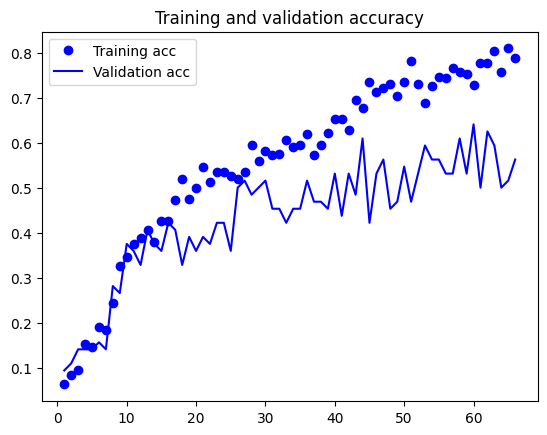

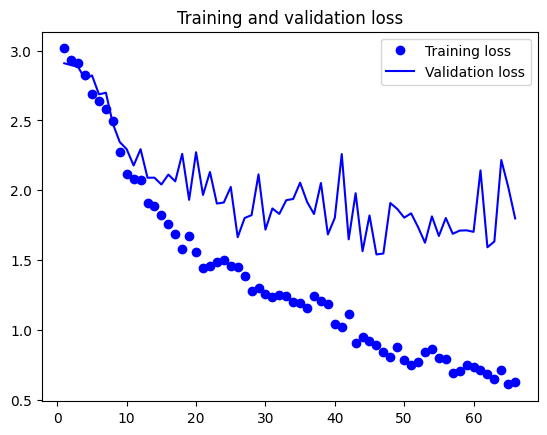

In [100]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_trained = range(1, len(acc) + 1)

plt.plot(epoch_trained, acc, 'bo', label='Training acc')
plt.plot(epoch_trained, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epoch_trained, loss, 'bo', label='Training loss')
plt.plot(epoch_trained, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [101]:
# Loading the automatically saved model
model_reloaded = load_model(model_path  + model_name + '.h5')

# Saving the best model in the correct path and format
root_directory = os.getcwd()
checkpoint_dir = os.path.join(root_directory, checkpoint_no)
model_name_temp = os.path.join(checkpoint_dir, model_name + '.h5')
model_reloaded.save(model_name_temp)

# Deletion of the automatically created folder under Model Checkpoint File.
folder_name_temp = os.path.join(checkpoint_dir, model_name)
shutil.rmtree(folder_name_temp, ignore_errors=True)
best_model = load_model(model_name_temp)

In [102]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(dataframe= test_df,x_col="File_Path",y_col="Label",target_size=(224,224), batch_size=batch_size)

test_loss, test_acc = best_model.evaluate(test_generator, steps=test_steps)
print()
print('Test Accuracy:', test_acc)

Found 79 validated image filenames belonging to 19 classes.
1/1 [==============================] - 0s 204ms/step - loss: 1.1850 - acc: 0.5938

Test Accuracy: 0.59375


In [103]:
img_height = 224
img_width = 224
pk.dump(img_height, open(checkpoint_dir+ '\\' +'img_height.pkl', 'wb'))
pk.dump(img_width, open(checkpoint_dir+ '\\' +'img_width.pkl', 'wb'))
# current best stuff
df = pd.read_csv(checkpoint_no + '/' + 'class_assignment_df_' + model_name + '.csv')
df = df.sort_values(by=['Category'], ascending=True)
categories = df['Category'].tolist()  


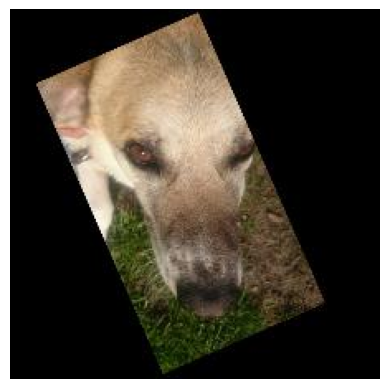

[[1 1 0 1 1 0 1 0 1 1 1 0 1 0 0 1 1 0 1]]

------------------------------------
Predicted Class:  122
Predicted Class:  129
Predicted Class:  186
Predicted Class:  192
Predicted Class:  202
Predicted Class:  291
Predicted Class:  363
Predicted Class:  372
Predicted Class:  397
Predicted Class:  444
Predicted Class:  448
Predicted Class:  458
------------------------------------


In [109]:
img_pred = cv2.imread('photos/val/122/122.0.jpg')

plt.imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
img_pred = cv2.resize(img_pred,(img_height,img_width))
img_pred = np.reshape(img_pred,[1,img_height,img_width,3])
classes = (best_model.predict(img_pred)).astype("int32")
# find index of 1 in classes
print(classes)
index = np.where(classes == 1)
index = index[1]


print()
print('------------------------------------')
for i in range(len(index)):
    print('Predicted Class: ' , categories[index[i]])
print('------------------------------------')